# Installation

Nowadays, most GPU packages are easy to install: Just do a `Pkg.add("CUDA")` and everything should work out-of-the-box. The only thing you need, is a functional NVIDIA driver, but you don't need to install the CUDA toolkit:

In [1]:
#using Pkg
#Pkg.add("CUDA")

In [2]:
using CUDA

With CUDA.jl, a good way to check if the package is functional is to call the `versioninfo()` function. Like `Base.versioninfo()`, this will print some information on the available hardware and loaded libraries:

In [3]:
CUDA.versioninfo()

CUDA toolkit 11.3.1, artifact installation
CUDA driver 11.3.0
NVIDIA driver 465.31.0

Libraries: 
- CUBLAS: 11.5.1
- CURAND: 10.2.4
- CUFFT: 10.4.2
- CUSOLVER: 11.1.2
- CUSPARSE: 11.6.0
- CUPTI: 14.0.0
- NVML: 11.0.0+465.31
- CUDNN: 8.20.0 (for CUDA 11.3.0)
- CUTENSOR: 1.3.0 (for CUDA 11.2.0)

Toolchain:
- Julia: 1.6.2
- LLVM: 11.0.1
- PTX ISA support: 3.2, 4.0, 4.1, 4.2, 4.3, 5.0, 6.0, 6.1, 6.3, 6.4, 6.5, 7.0
- Device capability support: sm_35, sm_37, sm_50, sm_52, sm_53, sm_60, sm_61, sm_62, sm_70, sm_72, sm_75, sm_80

2 devices:
  0: NVIDIA Quadro RTX 5000 (sm_75, 13.857 GiB / 15.744 GiB available)
  1: NVIDIA GeForce GTX TITAN (sm_35, 5.930 GiB / 5.941 GiB available)


Note that by checking the versions of all libraries used by CUDA.jl, this may initially trigger a download of said libraries, so depending on your internet connection it might take a minute or two before you see any output.

With oneAPI.jl, which currently only supports Linux, the situation is even easier as the driver is part of the Linux kernel. AMDGPU.jl requires some more set-up, but it's documented in the repository: https://amdgpu.juliagpu.org/stable/#Setup-Instructions

## Options for CUDA toolkit selection

There's two special environment variables that can currently be used to influence the CUDA toolkit that's used:
- `JULIA_CUDA_VERSION`: set to e.g. `11.0` to install a specific version
- `JULIA_CUDA_USE_BINARYBUILDER`: set to `false` to use a local CUDA installation

It is **not** recommended to use these environment variables unless you have a really good reason. There's also no guarantee that they will remain supported. If you have any issues with the automatically-installed CUDA toolkit, please let us know instead of just disabling the functionality.

# Array programming

The easiest way to program GPUs in Julia is by using array operations. In CUDA.jl, that's donen with the `CuArray` type:

In [4]:
a = CuArray([1,2,3,4])

4-element CuArray{Int64, 1}:
 1
 2
 3
 4

In [5]:
a .+= 1

4-element CuArray{Int64, 1}:
 2
 3
 4
 5

These two operations demonstrate the different tasks that `CuArray` has:
1. a container for storing GPU data and managing its lifetime
2. a abstraction for executing parallel operations on the GPU

## Scalar indexing

It's crucial to remember that `CuArray` is an abstraction that derives parallelism from its operations. CUDA.jl is **not** a parallelizing compiler, which e.g. means you cannot use element-wise for loops and expect those to execute efficiently on the GPU:

In [6]:
# ignore this
task_local_storage(:ScalarIndexing, CUDA.GPUArrays.ScalarWarn);

In [7]:
for i in eachindex(a)
    a[i] += 1
end
a

┌ Warning: Performing scalar indexing on task Task (runnable) @0x00007f836742cfd0.
│ Invocation of getindex resulted in scalar indexing of a GPU array.
│ This is typically caused by calling an iterating implementation of a method.
│ Such implementations *do not* execute on the GPU, but very slowly on the CPU,
│ and therefore are only permitted from the REPL for prototyping purposes.
│ If you did intend to index this array, annotate the caller with @allowscalar.
└ @ GPUArrays /home/tim/Julia/depot/packages/GPUArrays/8dzSJ/src/host/indexing.jl:56


4-element CuArray{Int64, 1}:
 3
 4
 5
 6

As you can see, the operation *did* complete successfully, but with a nasty warning. In fact, the operation did not complete on the GPU, but on the CPU, while fetching and writing each value back separately. Needless to say, that's extremely slow.

In the latest version of CUDA.jl, scalar indexing is disallowed by default in non-interactive code. With interactive sessions (e.g. in the REPL, or here in Jupyter), the behavior is still allowed because it's a convenient tool to get up to speed when porting code. You can explicitly enable or disable the feature too:

In [8]:
CUDA.allowscalar(false)
a[1]

LoadError: Scalar indexing is disallowed.
Invocation of getindex resulted in scalar indexing of a GPU array.
This is typically caused by calling an iterating implementation of a method.
Such implementations *do not* execute on the GPU, but very slowly on the CPU,
and therefore are only permitted from the REPL for prototyping purposes.
If you did intend to index this array, annotate the caller with @allowscalar.

## Array interface

The `CuArray` type is implemented to resemble `Base.Array`, making it easy to get up to speed, but also making it possible to write generic code that works on all kinds of arrays:

In [9]:
# allocate data
a = CuArray{Float32}(undef, 10)

10-element CuArray{Float32, 1}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [10]:
# allocate & initialize
b = CuArray{Float32}([i for i in 1:length(a)])

10-element CuArray{Float32, 1}:
  1.0
  2.0
  3.0
  4.0
  5.0
  6.0
  7.0
  8.0
  9.0
 10.0

In [11]:
copyto!(a, b)

10-element CuArray{Float32, 1}:
  1.0
  2.0
  3.0
  4.0
  5.0
  6.0
  7.0
  8.0
  9.0
 10.0

In [12]:
fill!(a, 42)

10-element CuArray{Float32, 1}:
 42.0
 42.0
 42.0
 42.0
 42.0
 42.0
 42.0
 42.0
 42.0
 42.0

In [13]:
similar(a)

10-element CuArray{Float32, 1}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

Some array operations don't take an array type, so it's impossible to dispatch to a GPU-specific version. For those, the CUDA module has an unexported version:

In [14]:
c = CUDA.ones(length(a))

10-element CuArray{Float32, 1}:
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0

In [15]:
d = CUDA.rand(length(a))

10-element CuArray{Float32, 1}:
 0.13350801
 0.6619743
 0.1477642
 0.33162123
 0.2251849
 0.14685442
 0.56701154
 0.50537854
 0.46373102
 0.15597753

## Vendor libraries

For actually useful operations that perform some computations on the GPU, we integrate with NVIDIA's libraries that provide precompiled kernels for many operations:

In [16]:
# CUBLAS
using LinearAlgebra
mul!(d, CUDA.rand(10,10), d)

10-element CuArray{Float32, 1}:
 1.725873
 1.4458233
 1.253923
 1.2242541
 1.8569229
 1.7825263
 2.0259395
 1.1662793
 1.4785022
 1.5827265

In [17]:
# CURAND
using Random
rand!(d)

10-element CuArray{Float32, 1}:
 0.8883666
 0.9967026
 0.88738567
 0.92704606
 0.96238786
 0.0015361655
 0.8063529
 0.39111987
 0.7241098
 0.59699225

In [18]:
# CUSOLVER
qr(d);

In [19]:
# CUFFT
using AbstractFFTs
fft(d)

10-element CuArray{ComplexF32, 1}:
      7.182f0 + 0.0f0im
  0.8358591f0 - 0.9916395f0im
 -0.4411934f0 - 0.012710698f0im
 0.70361394f0 - 0.11756455f0im
 -0.9250496f0 - 0.49764034f0im
  1.3552058f0 + 0.0f0im
 -0.9250496f0 + 0.49764034f0im
 0.70361394f0 + 0.11756455f0im
 -0.4411934f0 + 0.012710698f0im
  0.8358591f0 + 0.9916395f0im

Note that this is one of the areas where CUDA.jl surpasses AMDGPU.jl and definitely oneAPI.jl: Writing wrappers for these libraries and integrating them with the relevant Julia interfaces or packages is not a difficult, but a very time consuming job.

To help with that, CUDA.jl also exposes all of the underlying C APIs, and makes them compatible with the CuArray type. For example, let's find the index of the smallest value using the `cublasIsamin` function:

In [20]:
out = Ref{Cint}()
CUBLAS.cublasIsamin_v2(CUBLAS.handle(), length(d), d, stride(d, 1), out)
out[]

6

In [21]:
findmin(d)

(0.0015361655f0, 6)

So if you're missing a certain wrapper, or you know how to implement e.g. some LinearAlgebra interface, please consider contributing to CUDA.jl! The CUBLAS APIs are well-documented, https://docs.nvidia.com/cuda/cublas/index.html#using-the-cublas-api, but often require domain expertise to properly interpret them and implement high-level wrappers.

## Higher-order abstractions

Although the CuArray type and its support for NVIDIA's vendor libraries is nice, it isn't really novel and could as well have been implemented in Python (and libraries like CuPy do exactly that). The real flexibility of Julia's arrays comes from its higher-order abstractions, where you combine the abstraction with custom code:

In [22]:
a = CUDA.ones(10)
broadcast(a) do x
    x += 1
end

10-element CuArray{Float32, 1}:
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0

In [23]:
# or written more familiarly:
a .+ 1

10-element CuArray{Float32, 1}:
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0

These abstractions are really powerful, because while we only need to provide a single generic implementation in CUDA.jl, it makes it possible to generate specialized kernels for your application. Many more are supported:

In [24]:
map(a) do x
    x + 1
end

10-element CuArray{Float32, 1}:
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0

In [25]:
reduce(+, a)

10.0f0

In [26]:
accumulate(+, a)

10-element CuArray{Float32, 1}:
  1.0
  2.0
  3.0
  4.0
  5.0
  6.0
  7.0
  8.0
  9.0
 10.0

It is important to note here that **CUDA.jl is not a tensor compiler**. It implements these abstractions directly, and generates scalar kernels. Generic functions that operate on other arrays (like mapping over `eachcol`, or using `eachslice`) do not directly result in a GPU kernel:

In [27]:
a = CUDA.ones(10, 10)
broadcast(eachcol(a)) do x
    sum(x)
end

10-element Vector{Float32}:
 10.0
 10.0
 10.0
 10.0
 10.0
 10.0
 10.0
 10.0
 10.0
 10.0

Performing the `sum` within the `map` results in one kernel launch per column, which is slow and doesn't efficiently use the GPU:

In [28]:
using BenchmarkTools
@benchmark CUDA.@sync broadcast(eachcol($a)) do x
    sum(x)
end

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  178.280 μs …  39.192 ms  ┊ GC (min … max): 0.00% … 28.66%
 Time  (median):     192.730 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   236.726 μs ± 981.659 μs  ┊ GC (mean ± σ):  2.88% ±  0.69%

  ▄█▇▃                                                          ▁
  █████▆▆▆▅▄▃▅▄▄▁▁▁▁▁▁▃▅▄▄▁▁▁▁▁▁▃▅▄▆▇▆▆▅▅▃▅▄▃▄▁▃▅▄▅▄▆██▇▅▄▄▅▄▄▇ █
  178 μs        Histogram: log(frequency) by time        691 μs <

 Memory estimate: 26.27 KiB, allocs estimate: 645.

Instead, if the array operation supports it, you should merge them into a single invocation:

In [29]:
sum(a; dims=2)

10×1 CuArray{Float32, 2}:
 10.0
 10.0
 10.0
 10.0
 10.0
 10.0
 10.0
 10.0
 10.0
 10.0

In [30]:
@benchmark CUDA.@sync sum(a; dims=2)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  10.820 μs … 722.780 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     11.700 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   12.734 μs ±  19.503 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

          ▁▅▆▆▇▆█▄▃▃▂▅▂▁▂                                       
  ▁▁▁▂▂▃▅▆█████████████████▇▆▅▄▄▃▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▃
  10.8 μs         Histogram: frequency by time         13.9 μs <

 Memory estimate: 2.27 KiB, allocs estimate: 59.

In other cases, the operation will just refuse the compile because very few array operations are supported in actual device code:

In [31]:
broadcast(a, eachcol(a)) do x,Y
    x + sum(Y)
end

LoadError: GPU compilation of kernel broadcast_kernel(CUDA.CuKernelContext, CuDeviceMatrix{Float32, 1}, Base.Broadcast.Broadcasted{Nothing, Tuple{Base.OneTo{Int64}, Base.OneTo{Int64}}, var"#10#11", Tuple{Base.Broadcast.Extruded{CuDeviceMatrix{Float32, 1}, Tuple{Bool, Bool}, Tuple{Int64, Int64}}, Base.Broadcast.Extruded{Vector{CuArray{Float32, 1}}, Tuple{Bool}, Tuple{Int64}}}}, Int64) failed
KernelError: passing and using non-bitstype argument

Argument 4 to your kernel function is of type Base.Broadcast.Broadcasted{Nothing, Tuple{Base.OneTo{Int64}, Base.OneTo{Int64}}, var"#10#11", Tuple{Base.Broadcast.Extruded{CuDeviceMatrix{Float32, 1}, Tuple{Bool, Bool}, Tuple{Int64, Int64}}, Base.Broadcast.Extruded{Vector{CuArray{Float32, 1}}, Tuple{Bool}, Tuple{Int64}}}}, which is not isbits:
  .args is of type Tuple{Base.Broadcast.Extruded{CuDeviceMatrix{Float32, 1}, Tuple{Bool, Bool}, Tuple{Int64, Int64}}, Base.Broadcast.Extruded{Vector{CuArray{Float32, 1}}, Tuple{Bool}, Tuple{Int64}}} which is not isbits.
    .2 is of type Base.Broadcast.Extruded{Vector{CuArray{Float32, 1}}, Tuple{Bool}, Tuple{Int64}} which is not isbits.
      .x is of type Vector{CuArray{Float32, 1}} which is not isbits.



Tensor packages like Tullio.jl can help here, making it possible to express complex expressions in a way that can still get compiled to a single kernel:

In [32]:
#Pkg.add(["Tullio", "CUDAKernels", "KernelAbstractions"])
using Tullio
using CUDA, CUDAKernels, KernelAbstractions

In [33]:
@tullio x[i,j] := a[i,j] + a[k,j]

10×10 CuArray{Float32, 2}:
 20.0  20.0  20.0  20.0  20.0  20.0  20.0  20.0  20.0  20.0
 20.0  20.0  20.0  20.0  20.0  20.0  20.0  20.0  20.0  20.0
 20.0  20.0  20.0  20.0  20.0  20.0  20.0  20.0  20.0  20.0
 20.0  20.0  20.0  20.0  20.0  20.0  20.0  20.0  20.0  20.0
 20.0  20.0  20.0  20.0  20.0  20.0  20.0  20.0  20.0  20.0
 20.0  20.0  20.0  20.0  20.0  20.0  20.0  20.0  20.0  20.0
 20.0  20.0  20.0  20.0  20.0  20.0  20.0  20.0  20.0  20.0
 20.0  20.0  20.0  20.0  20.0  20.0  20.0  20.0  20.0  20.0
 20.0  20.0  20.0  20.0  20.0  20.0  20.0  20.0  20.0  20.0
 20.0  20.0  20.0  20.0  20.0  20.0  20.0  20.0  20.0  20.0

At some point you may need even more control, or better performance. For that, you can write your own kernels.

# Kernel programming

Where array operations have implicit parallelism that CUDA.jl can use to execute the operation in parallel on your GPU, with kernels the programmer is responsible to apply the available parallel execution resources to the operation at hand.

At a high level, that's pretty easy, you just need to write a scalar function and launch that function in parallel using the `@cuda` macro and its `threads` keyword argument:

In [34]:
function vadd(c, a, b)
    i = threadIdx().x
    c[i] = a[i] + b[i]
    return
end

a = CuArray(1:10)
b = CuArray(2:2:20)
c = similar(a)
@cuda threads=length(a) vadd(c, a, b)
c

10-element CuArray{Int64, 1}:
  3
  6
  9
 12
 15
 18
 21
 24
 27
 30

But kernel programming quickly becomes much more tricky, because:
- you need to respect hardware limitations
- you need to efficiently use hardware resources
- not every operation maps cleanly on a scalar kernel

## Hardware limitations

For example, let's run our `vadd` kernel on a larger array:

In [35]:
a = CuArray(1:100000)
b = CuArray(2:2:200000)
c = similar(a)
@cuda threads=length(a) vadd(c, a, b)

LoadError: CUDA error: invalid argument (code 1, ERROR_INVALID_VALUE)

The reason this fails is due to launching too many threads:

In [36]:
CUDA.attribute(device(), CUDA.DEVICE_ATTRIBUTE_MAX_THREADS_PER_BLOCK)

1024

Instead, we need to launch multiple so-call *thread blocks* and adapt our kernel index calculation:

In [37]:
function vadd(c, a, b)
    i = threadIdx().x + (blockIdx().x - 1) * blockDim().x
    if i <= length(a)
        c[i] = a[i] + b[i]
    end
    return
end
@cuda threads=1024 blocks=cld(length(a),1024) vadd(c, a, b)
c

100000-element CuArray{Int64, 1}:
      3
      6
      9
     12
     15
     18
     21
     24
     27
     30
     33
     36
     39
      ⋮
 299967
 299970
 299973
 299976
 299979
 299982
 299985
 299988
 299991
 299994
 299997
 300000

### Occupancy API

Hard-coding a limit of 1024 threads, or even looking up the device limit, is insufficient. In reality, maximum number of threads you can launch also depends on the kernel, and how many hardware resources it uses.

You can figure out the actual thread limit by compiling the kernel and before launching it inspect its properties:

In [38]:
kernel = @cuda launch=false vadd(c, a, b)

CUDA.HostKernel{typeof(vadd), Tuple{CuDeviceVector{Int64, 1}, CuDeviceVector{Int64, 1}, CuDeviceVector{Int64, 1}}}(vadd, CuContext(0x0000000001918640, instance 3a1b6266f688dda4), CuModule(Ptr{Nothing} @0x0000000031b4aca0, CuContext(0x0000000001918640, instance 3a1b6266f688dda4)), CuFunction(Ptr{Nothing} @0x0000000031b56300, CuModule(Ptr{Nothing} @0x0000000031b4aca0, CuContext(0x0000000001918640, instance 3a1b6266f688dda4))))

In [39]:
CUDA.maxthreads(kernel)

1024

With the occupancy API, you can figure out what a good number of threads is (not only respecting device limits, but optimizing actual resource usage), and how many blocks you should ideally launch to optimally use the GPU:

In [40]:
config = CUDA.launch_configuration(kernel.fun)

(blocks = 48, threads = 1024)

With this information, we can compute the actual launch configuration and continue launching the kernel:

In [41]:
@show threads = min(length(a), config.threads)
@show blocks = cld(length(a), threads)
kernel(c, a, b; threads, blocks)

threads = min(length(a), config.threads) = 1024
blocks = cld(length(a), threads) = 98


Note that the occupancy API recommended launching at least 48 blocks, but our array sizes required 98 blocks of 1024 threads. This is not a problem, but may come at a cost. If you want to avoid this, look into adding a grid-stride loop to your kernel.

## Parallel programming

Another problem with GPU programming is that not all operations map cleanly onto scalar kernels. As a simple example, let's try and implement a kernel that reduces all the values in an array according to a given operation.

### Naive loop

You might start off with a simple `for` loop doing the reduction on the GPU as you would on the CPU:

In [42]:
function reduce_singlethread(op, a, b)
    for i in 1:length(a)
        b[] = op(b[], a[i])
    end
    return
end

a = CuArray(1:16)
b = CuArray([0])
@cuda threads=1 reduce_singlethread(+, a, b)
CUDA.@allowscalar b[]

136

In [43]:
# just to be sure
sum(1:16)

136

In [44]:
@benchmark CUDA.@sync @cuda threads=1 reduce_singlethread(+, $(CUDA.rand(1024,1024)), $(CUDA.zeros(1)))

BenchmarkTools.Trial: 79 samples with 1 evaluation.
 Range (min … max):  61.489 ms … 82.508 ms  ┊ GC (min … max): 0.00% … 6.18%
 Time  (median):     63.249 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   63.835 ms ±  3.163 ms  ┊ GC (mean ± σ):  0.28% ± 1.30%

  █▁▅                                                          
  ███▃▁▁▄▃▄▄▇▆▆▃▃▆▄▁▃▄▅▄▃▃▁▁▁▁▁▃▁▁▄▁▁▁▁▁▁▁▁▁▁▁▁▃▁▁▁▃▁▁▁▃▁▁▁▁▃ ▁
  61.5 ms         Histogram: frequency by time        72.5 ms <

 Memory estimate: 2.08 MiB, allocs estimate: 136379.

This is a bad implementation though! It only uses a single thread, defeating the point of using a GPU with its thousands of threads.

### Atomics

To benefit from the GPU, we *need* to launch multiple threads. Since that would trample over the output value, we could try and use atomics:

In [45]:
function reduce_atomic(op, a, b)
    i = threadIdx().x + (blockIdx().x - 1) * blockDim().x
    @atomic b[] = op(b[], a[i])
    return
end

a = CuArray(1:16)
b = CuArray([0])
@cuda threads=16 reduce_atomic(+, a, b)
CUDA.@allowscalar b[]

136

In [46]:
@benchmark CUDA.@sync @cuda threads=1024 blocks=1024 reduce_atomic(+, $(CUDA.rand(1024,1024)), $(CUDA.zeros(1)))

BenchmarkTools.Trial: 2749 samples with 1 evaluation.
 Range (min … max):  1.739 ms …   6.413 ms  ┊ GC (min … max): 0.00% … 71.37%
 Time  (median):     1.740 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   1.817 ms ± 189.713 μs  ┊ GC (mean ± σ):  0.28% ±  2.75%

  █                             ▄                   ▂▂▁▁       
  █▁▁▁▁▁▁▁▄▁▃▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▅██▆▅▃▃▁▁▁▁▁▁▁▁▅▅▅▅▅▄████▇▆▆▆█ █
  1.74 ms      Histogram: log(frequency) by time      2.18 ms <

 Memory estimate: 19.02 KiB, allocs estimate: 1203.

This still isn't great though: Atomic operations are expensive, and result in serialization of execution.

### Parallel block reduction

We really want a kind of parallel reduction where threads can indepedently perform computations, only to synchronize when absolutely necessary. One possible such parallel strategy looks as follows:

<div>
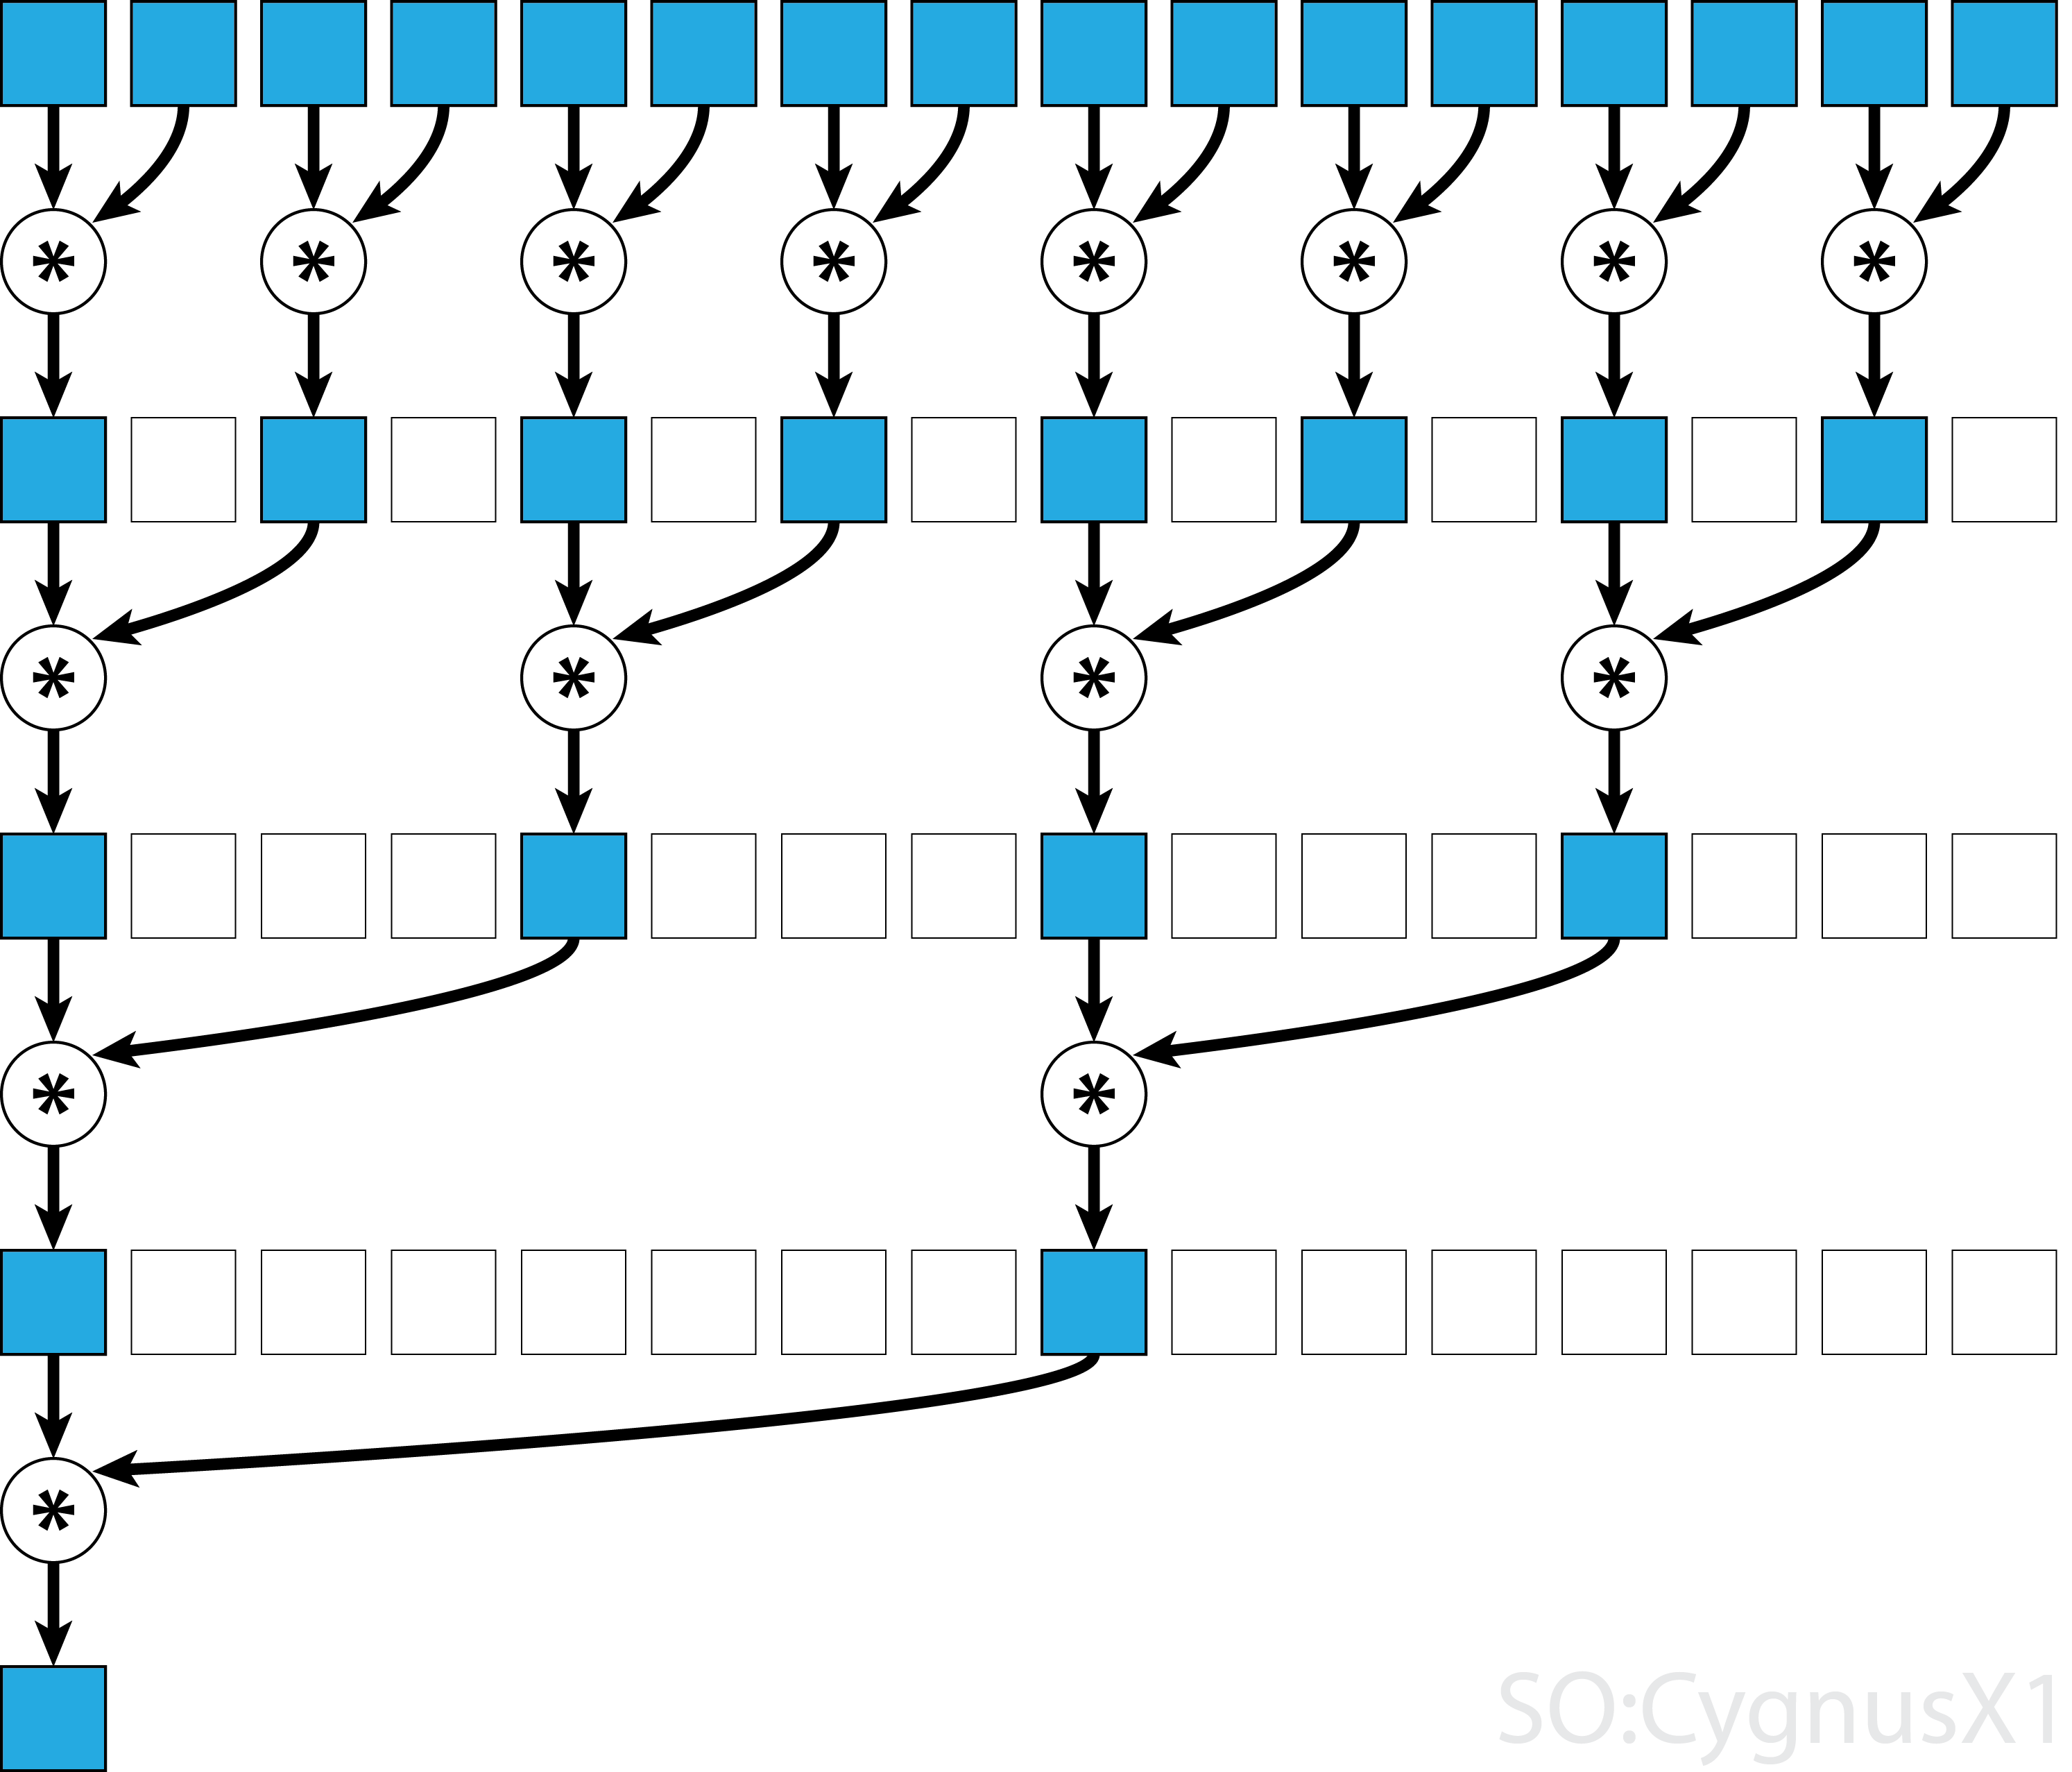
</div>

These kinds parallel algorithms can be tricky to implement though, so let's start with a single-block version:

In [47]:
function reduce_block(op, a, b)
    threads = blockDim().x
    thread = threadIdx().x

    # parallel reduction of values in a block
    d = 1
    while d < threads
        sync_threads()
        index = 2 * d * (thread-1) + 1
        @inbounds if index <= threads
            @cuprintln "thread $thread: a[$index] + a[$(index+d)] = $(a[index]) + $(a[index+d]) = $(op(a[index], a[index+d]))"
            a[index] = op(a[index], a[index+d])
        end
        d *= 2
        thread == 1 && @cuprintln()
    end
    
    if thread == 1
        b[] = a[1]
    end
    
    return
end

a = CuArray(1:16)
b = CuArray([0])
@cuda threads=length(a) reduce_block(+, a, b)
CUDA.@allowscalar b[]

136

Now let's extend that to a reduction of the entire array (with more elements than fit in a single block) using a simple `for` loop that first reduces across blocks. Such loops aren't always bad: Here, the loop is executed by all threads, in parallel, so we don't throw away the parallel nature of the GPU:

In [48]:
function reduce_grid(op, a, b)
    threads = blockDim().x
    thread = threadIdx().x
    
    # serial reduction of values across blocks
    i = thread+threads
    while i <= length(a)
        a[thread] = op(a[thread], a[i])
        i += threads
    end

    # parallel reduction of values in a block
    d = 1
    while d < threads
        sync_threads()
        index = 2 * d * (thread-1) + 1
        @inbounds if index <= threads
            a[index] = op(a[index], a[index+d])
        end
        d *= 2
    end
    
    if thread == 1
        b[] = a[1]
    end
    
    return
end

a = CuArray(1:16)
b = CuArray([0])
@cuda threads=16 reduce_grid(+, a, b)
CUDA.@allowscalar b[]

thread 1: a[1] + a[2] = 1 + 2 = 3
thread 2: a[3] + a[4] = 3 + 4 = 7
thread 3: a[5] + a[6] = 5 + 6 = 11
thread 4: a[7] + a[8] = 7 + 8 = 15
thread 5: a[9] + a[10] = 9 + 10 = 19
thread 6: a[11] + a[12] = 11 + 12 = 23
thread 7: a[13] + a[14] = 13 + 14 = 27
thread 8: a[15] + a[16] = 15 + 16 = 31

thread 1: a[1] + a[3] = 3 + 7 = 10
thread 2: a[5] + a[7] = 11 + 15 = 26
thread 3: a[9] + a[11] = 19 + 23 = 42
thread 4: a[13] + a[15] = 27 + 31 = 58

thread 1: a[1] + a[5] = 10 + 26 = 36
thread 2: a[9] + a[13] = 42 + 58 = 100

thread 1: a[1] + a[9] = 36 + 100 = 136



136

<div>
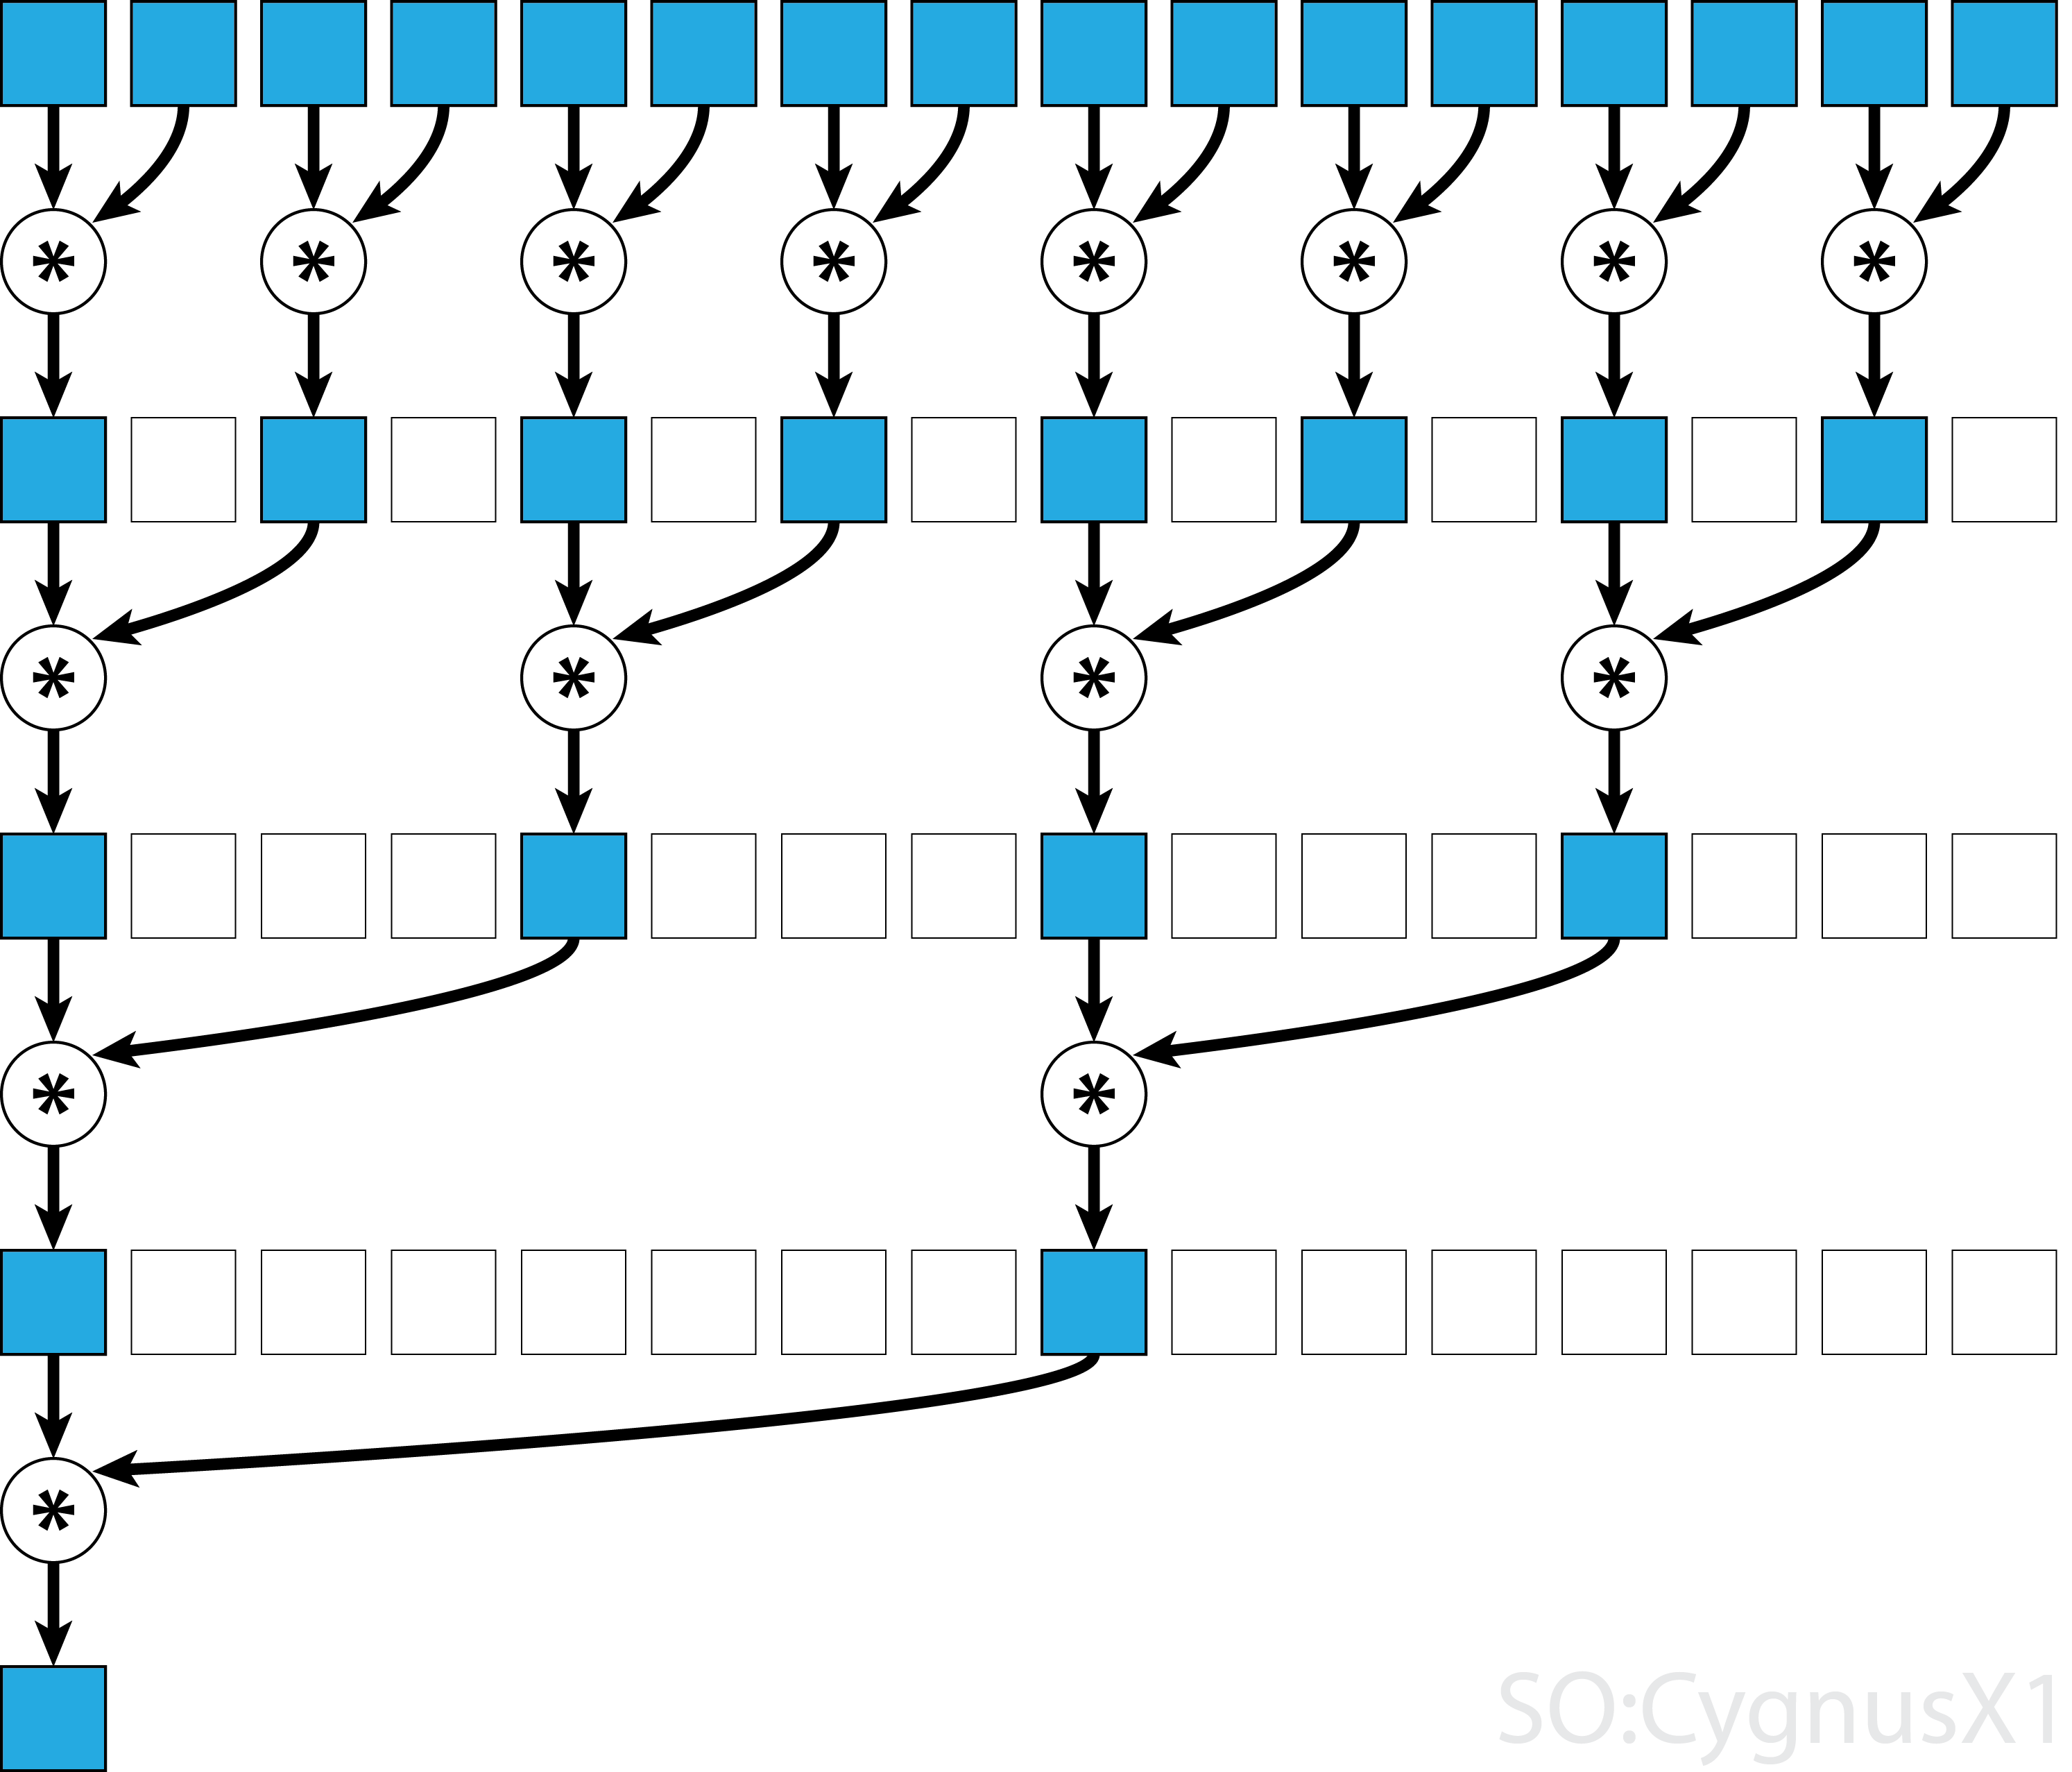
</div>

In [49]:
@benchmark CUDA.@sync @cuda threads=1024 reduce_grid(+, $(CUDA.rand(1024,1024)), $(CUDA.zeros(1)))

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  295.950 μs …   5.381 ms  ┊ GC (min … max): 0.00% … 95.94%
 Time  (median):     305.891 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   328.297 μs ± 115.653 μs  ┊ GC (mean ± σ):  0.30% ±  1.38%

  ▇█▄  ▁▃                           ▁▁                    ▁     ▁
  ████▅███▁▁▁▁▁▃▁▁▃▁▁▄▅▅▄▁▅▅▃▁▁▄▃▃▁▅██▇▆▄▃▁▁▅▃▄▄▃▅▅▃▃▄▄▄▅▆██▇▆▇ █
  296 μs        Histogram: log(frequency) by time        790 μs <

 Memory estimate: 320 bytes, allocs estimate: 6.

Quite a bit better, but not ideal since we're only launching a single block now. That's still underutilizing the GPU, which needs multiple blocks so that it can switch between them to hide latency.


### Atomic grid reduction

If we want to launch multiple blocks performing block reduction in parallel, we need a way to reduce the resulting value from each block. Sadly, we can't perform that step in parallel: Blocks are independent, and may not even run at the same time, so we can't synchronize between threads from different blocks.

However, going back to the beginning, we can use atomics to directly write to the output from each block:

In [50]:
function reduce_grid_atomic(op, a, b)
    threads = blockDim().x
    thread = threadIdx().x
    block = blockIdx().x
    offset = (block-1) * threads

    # parallel reduction of values in a block
    d = 1
    while d < threads
        sync_threads()
        index = 2 * d * (thread-1) + 1
        @inbounds if index <= threads
            a[offset+index] = op(a[offset+index], a[offset+index+d])
        end
        d *= 2
    end
    
    # atomic reduction of this block's value
    if thread == 1
        @atomic b[] = op(b[], a[offset + 1])
    end
    
    return
end

a = CuArray(1:16)
b = CuArray([0])
@cuda threads=4 blocks=4 reduce_grid_atomic(+, a, b)
CUDA.@allowscalar b[]

136

In [51]:
@benchmark CUDA.@sync @cuda threads=1024 blocks=1024 reduce_grid_atomic(+, $(CUDA.rand(1024,1024)), $(CUDA.zeros(1)))

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  60.800 μs … 622.891 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     61.450 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   64.258 μs ±  30.257 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▂█                                                            
  ██▄▂▂▂▂▂▂▂▂▂▁▂▂▁▁▂▁▂▁▂▂▁▁▂▁▁▁▁▁▁▂▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▂▁▁▂▁▁▁▂▂▂▂▂ ▂
  60.8 μs         Histogram: frequency by time         94.3 μs <

 Memory estimate: 1.72 KiB, allocs estimate: 96.

### Shared memory

Another common optimization comes from the fact that blocks of threads are executed on separate processors that have their own memory shared between the threads running on that multiprocessor. Accessing that memory is faster than going to global memory, so it is often used for caching loads, and for communicating betweent threads. Both those aspects apply here:

In [52]:
function reduce_grid_atomic_shmem(op, a::AbstractArray{T}, b) where {T}
    threads = blockDim().x
    thread = threadIdx().x
    block = blockIdx().x
    offset = (block-1) * threads

    # shared mem to buffer memory loads
    shared = @cuStaticSharedMem(T, (1024,))
    @inbounds shared[thread] = a[offset+thread]

    # parallel reduction of values in a block
    d = 1
    while d < threads
        sync_threads()
        index = 2 * d * (thread-1) + 1
        @inbounds if index <= threads
            shared[index] = op(shared[index], shared[index+d])
        end
        d *= 2
    end
    
    # atomic reduction
    if thread == 1
        @atomic b[] = op(b[], shared[1])
    end
    
    return
end

a = CuArray(1:16)
b = CuArray([0])
@cuda threads=4 blocks=4 reduce_grid_atomic_shmem(+, a, b)
CUDA.@allowscalar b[]

136

In [53]:
@benchmark CUDA.@sync @cuda threads=1024 blocks=1024 reduce_grid_atomic_shmem(+, $(CUDA.rand(1024,1024)), $(CUDA.zeros(1)))

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  58.280 μs …  1.038 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     59.430 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   64.992 μs ± 48.600 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █                                                           ▁
  █▆▅▁▁▁▁▁▁▁▁▁▁▁▁▃▁▁▁▁▁▁▄▁▁▄▆▁▃▃▁▃▁▁▄▁▁▁▄▄▄▅▅▄▁▁▁▃▁▃▁▁▁▁▁▁▁▁▄ █
  58.3 μs      Histogram: log(frequency) by time       396 μs <

 Memory estimate: 2.03 KiB, allocs estimate: 116.

The performance improvement isn't great, but that's because I'm using a powerful GPU with lots of global memory bandwith. On older or lower-end GPUs, using shared memory would be valuable:

In [54]:
device!(1) do
    @benchmark CUDA.@sync @cuda threads=1024 blocks=1024 reduce_grid_atomic(+, $(CUDA.rand(1024,1024)), $(CUDA.zeros(1)))
end

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  460.461 μs …  5.384 ms  ┊ GC (min … max): 0.00% … 92.02%
 Time  (median):     464.661 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   466.135 μs ± 82.397 μs  ┊ GC (mean ± σ):  0.31% ±  1.62%

                              ▁▂▂▃▄▆▆▆▇▅██▆▇▇▅▄▄▂▂▁             
  ▂▁▁▁▁▂▂▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▆▆▇████████████████████████▆▆▅▅▄▄▃▃▃ ▅
  460 μs          Histogram: frequency by time          467 μs <

 Memory estimate: 7.72 KiB, allocs estimate: 480.

In [55]:
device!(1) do
    @benchmark CUDA.@sync @cuda threads=1024 blocks=1024 reduce_grid_atomic_shmem(+, $(CUDA.rand(1024,1024)), $(CUDA.zeros(1)))
end

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  304.100 μs …  5.197 ms  ┊ GC (min … max): 0.00% … 95.08%
 Time  (median):     307.200 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   308.190 μs ± 67.270 μs  ┊ GC (mean ± σ):  0.32% ±  1.38%

                               ▁▃▃▄▄▄▆▅█▅▆▆▅▅▅▄▃▂▁▁             
  ▂▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▃▄▄▄▄▅▅▆▆▇▇█████████████████████▇▆▆▅▄▄▄▃▃▃▃ ▅
  304 μs          Histogram: frequency by time          309 μs <

 Memory estimate: 864 bytes, allocs estimate: 40.

### Conclusion

And like that, the story keeps going. We're already at some decent level of performance, but there's still ways to go. For example, the implementation of `sum` in CUDA.jl is still quite a bit faster:

In [56]:
@benchmark CUDA.@sync sum($(CUDA.rand(1024,1024)))

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  39.930 μs … 842.851 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     42.250 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   44.443 μs ±  27.361 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

            ▁▅▆▆█▆▄▃▂▁                                          
  ▂▁▂▂▂▃▃▄▅▇███████████▆▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂ ▃
  39.9 μs         Histogram: frequency by time         49.1 μs <

 Memory estimate: 3.94 KiB, allocs estimate: 97.

And for completeness, compared to `Base.sum`:

In [57]:
@benchmark sum($(rand(1024,1024)))

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  81.510 μs … 319.151 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     88.930 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   89.336 μs ±   3.838 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

      ▂▂▃▂▁      ▁▃▅▆▇███▆▄▃▂▂▁▁ ▁▁   ▁▁           ▁           ▂
  ▆▆▇██████▇▇▇▆▆▇███████████████████████▇██▇▇▇▇▇▆▇██▇▆▇▇▆▇▆▅▅▆ █
  81.5 μs       Histogram: log(frequency) by time       102 μs <

 Memory estimate: 0 bytes, allocs estimate: 0.

Ultimately though, this kind of implementation and optimization isn't specific to CUDA.jl. It's exactly the same principles as with CUDA C, at mostly the same abstraction level, just with a much more user friendly programming language. I'm stopping here because the implementation at this point is still reasonably portable across back-ends (i.e. AMDGPU.jl and oneAPI.jl). Other, more specific optimizations would include:
- tune the launch configuration and use dynamic shared memory
- avoid shared memory bank conflicts
- using warp communication intrinsics to directly write to other threads' registers
- analyse the access pattern to ensure all memory accesses are coalesced
- ...

# Profiling

To demonstrate the profiler, let's continue with the reduction from above and create a custom sum method:

In [58]:
function my_sum(a::AbstractArray{T}) where {T}
    b = CUDA.zeros(T, 1)

    kernel = @cuda launch=false reduce_grid_atomic_shmem(+, a, b)

    config = launch_configuration(kernel.fun)
    threads = min(config.threads, length(a))
    blocks = cld(length(a), threads)

    @cuda threads=threads blocks=blocks reduce_grid_atomic_shmem(+, a, b)

    CUDA.@allowscalar b[]
end

a = CUDA.rand(1024, 1024)
my_sum(a) ≈ sum(a)

true

## Application profiling

For profiling GPU applications, we should start with a high-level overview: the timeline. You can create a timeline by launching Julia under Nsight Systems, which can be downloaded from https://developer.nvidia.com/nsight-systems: `nsys launch julia`. In that session, which is fully interactive (so you can load, e.g., Revise), you can profile code by wrapping it in the `CUDA.@profile` macro:

In [59]:
CUDA.@profile begin
    my_sum(a)
end

┌ Warning: Calling CUDA.@profile only informs an external profiler to start.
│ The user is responsible for launching Julia under a CUDA profiler.
│ 
│ It is recommended to use Nsight Systems, which supports interactive profiling:
│ $ nsys launch julia
└ @ CUDA.Profile /home/tim/Julia/depot/packages/CUDA/lwSps/lib/cudadrv/profile.jl:71


524516.0f0

To improve the profile, there's a couple of things we can do:
- it's recommended to run your code twice, because of profiler inaccuracies on the first run
- by wrapping in `NVTX.@range`, the operations will be clearly denoted in the timeline
- to make sure the `NVTX.@range` includes all relevant operations, we make sure to synchronize using `CUDA.@sync`

The generated files can then be opened with NSight Systems' UI:

In [60]:
CUDA.@profile begin
    NVTX.@range "my_sum" CUDA.@sync my_sum(a)
    NVTX.@range "my_sum" CUDA.@sync my_sum(a)
end

524515.94f0

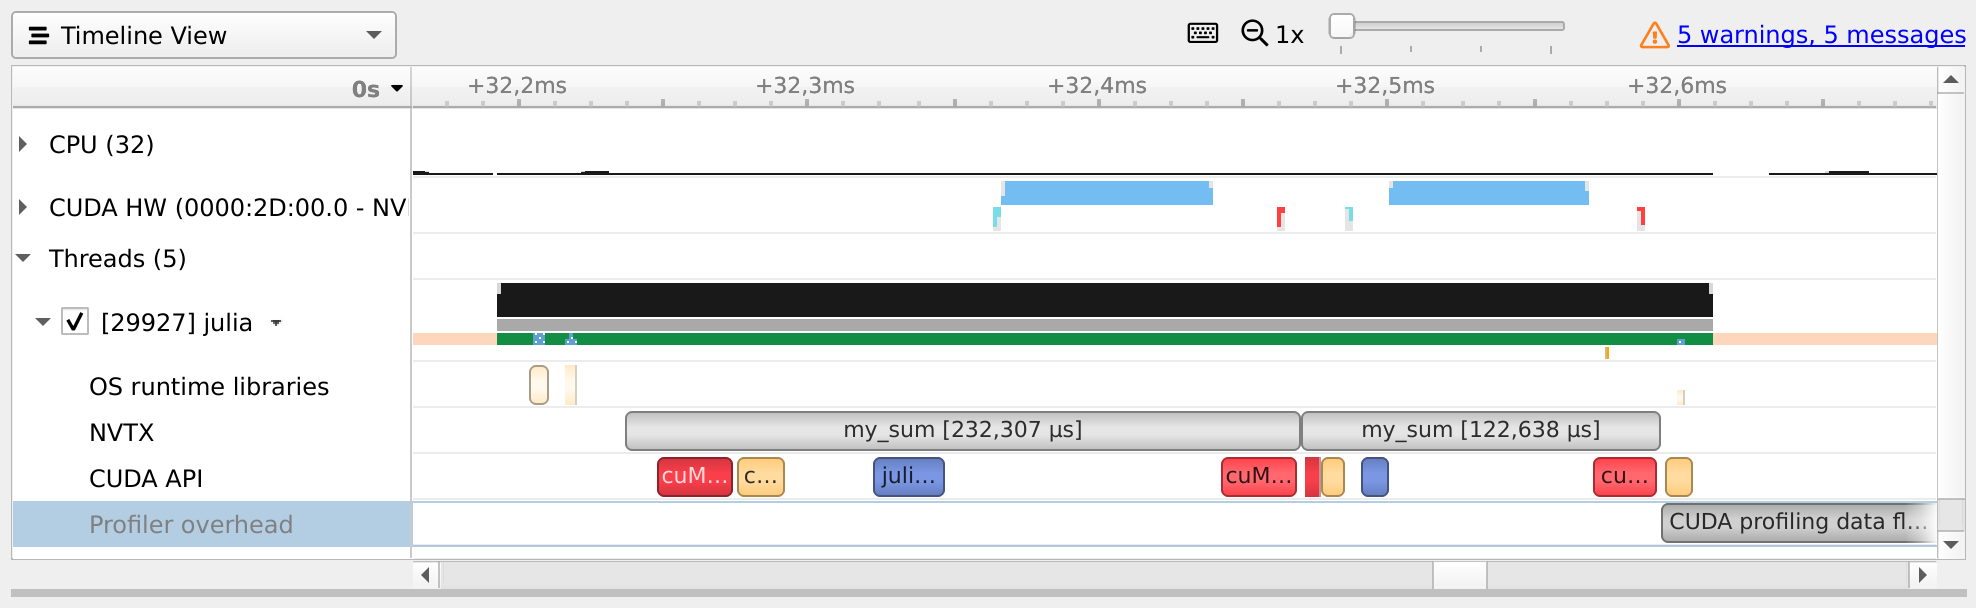

Nothing looks off in the timeline -- the only 'gap' is when waiting for the kernel (try adding a `NVTX.@range` to the copy, or to `CUDA.synchronize`).

These gaps can be detrimental to performance, though. For example, let's perform multiple sums (ideally we'd make our kernel N-dimensional, but lets ignore that for now):

In [61]:
# compute sums of everything but the last dimension
function my_multiple_sums(a::AbstractArray{T}) where {T}
    n = size(a)[end]
    dims = [axes(a)...][begin:end-1]
    sums = Vector{T}(undef, n)
    for x in 1:size(a,3)
        y = view(a, dims..., x)
        sums[x] = my_sum(y)
    end
    sums
end

my_multiple_sums(CUDA.rand(1024, 1024, 10))

10-element Vector{Float32}:
 523622.34
 523723.28
 524261.78
 524535.94
 524242.78
 524178.97
 524260.34
 524371.3
 524347.56
 524044.34

<div>
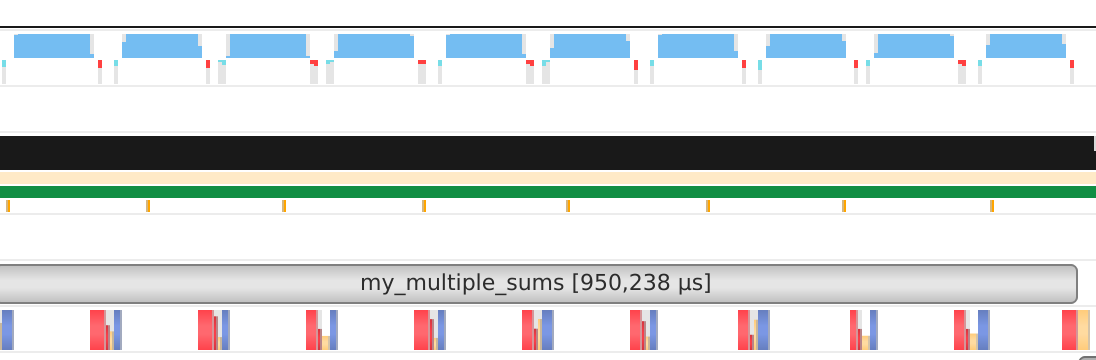
</div>

As expected, the gaps in the timeline (where the GPU is idle) are still there. Remember that these gaps are spent waiting for the kernel to finish so that we can copy back data from the GPU; that's useless as we only care about the sums after having computed them all. So let's modify our kernel to only copy to the CPU after everything is done:

In [62]:
function my_sum_lazy(a::AbstractArray{T}, b::CuArray) where {T}
    kernel = @cuda launch=false reduce_grid_atomic_shmem(+, a, b)

    config = launch_configuration(kernel.fun)
    threads = min(config.threads, length(a))
    blocks = cld(length(a), threads)

    @cuda threads=threads blocks=blocks reduce_grid_atomic_shmem(+, a, b)
end

function my_multiple_sums_lazy(a::AbstractArray{T}) where {T}
    n = size(a)[end]
    dims = [axes(a)...][begin:end-1]
    sums = CuVector{T}(undef, n)
    for x in 1:size(a,3)
        y = view(a, dims..., x)
        my_sum_lazy(y, view(sums, x))
    end
    Array(sums)
end

my_multiple_sums_lazy (generic function with 1 method)

<div>
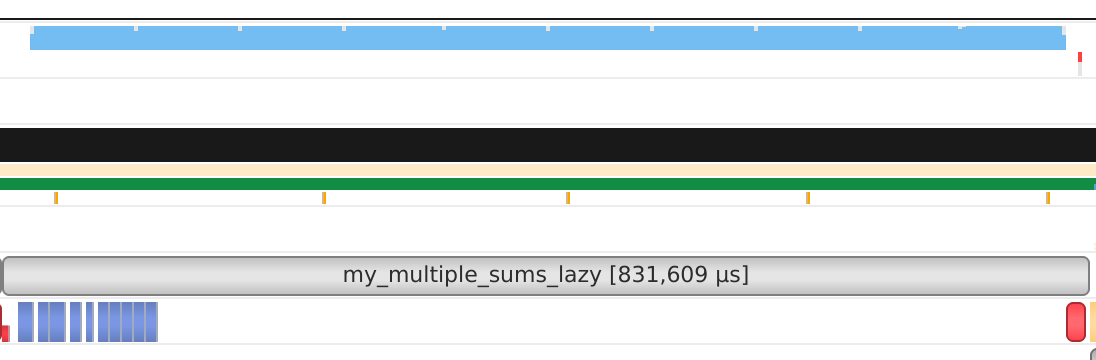
</div>

Much better, and quite a bit faster again! This kind of timeline optimization is **crucial** when working with real applications. It's important to keep the GPU busy by submitting enough work, and that's only possible if you optimize the submission path on the CPU side to avoid needless optimization.

## Kernel profiling

Sometimes it's important to really optimize a single kernel. We can do that using Nsight Compute, https://developer.nvidia.com/nsight-compute, by launching Julia under `nv-nsight-cu-cli --mode=launch`. Importing CUDA and doing any API call will make the session freeze, waiting for the profiler to attach.

So next, open the NSight Compute UI, and attach to the local Julia process. There's several ways to go about profiling a kernel, a good start is to enable `Profile > Auto Profile` and hit `Debug > Resume`. Calling our code will again freeze though, because some API calls fail, so disable `Debug > Break on error`.

Now you can select a kernel and inspect its performance characteristics:

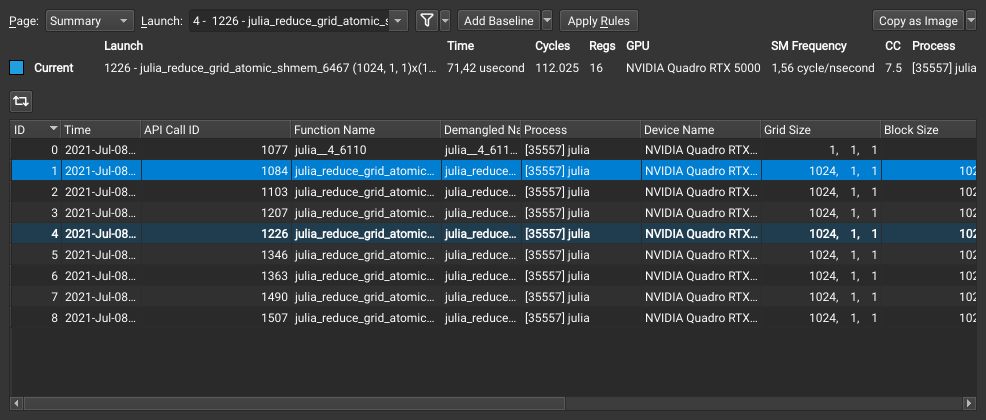

Here, for example, NSight Compute notices we have uncoalesced memory accesses (as predicted). Another good way to start the analysis is to look at which points in the code are sampled the most:

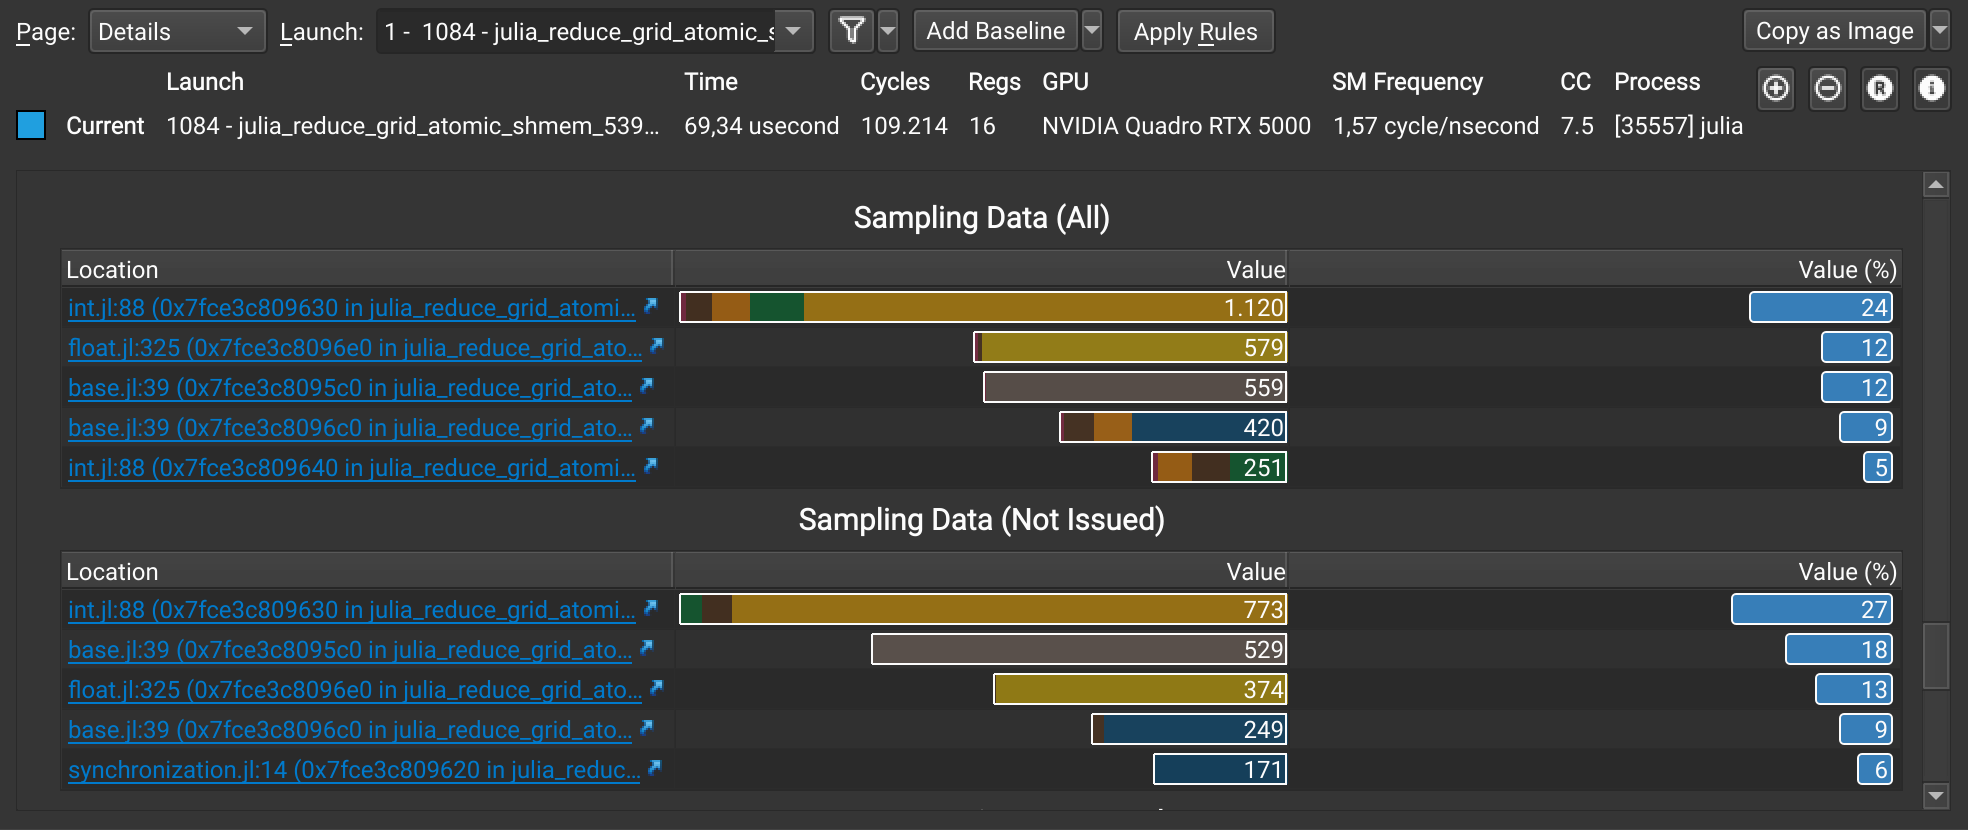

Looking at the PTX code, it's obvious this is the index calculation in the parallel reduction loop. Let's try and make it less expensive by changing it to 32-bit integers:

In [63]:
function reduce_grid_atomic_shmem_int32(op, a::AbstractArray{T}, b) where {T}
    threads = Int32(blockDim().x)
    thread = Int32(threadIdx().x)
    block = Int32(blockIdx().x)
    offset = (block-Int32(1)) * threads

    # shared mem to buffer memory loads
    shared = @cuStaticSharedMem(T, (1024,))
    @inbounds shared[thread] = a[offset+thread]

    # parallel reduction of values in a block
    d = Int32(1)
    while d < threads
        sync_threads()
        index = Int32(2) * d * (thread-Int32(1)) + Int32(1)
        @inbounds if index <= threads
            shared[index] = op(shared[index], shared[index+d])
        end
        d *= Int32(2)
    end

    # atomic reduction
    if thread == 1
        @atomic b[] = op(b[], shared[1])
    end

    return
end
@benchmark CUDA.@sync @cuda threads=1024 blocks=1024 reduce_grid_atomic_shmem_int32(+, $(CUDA.rand(1024,1024)), $(CUDA.zeros(1)))

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  55.000 μs … 718.692 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     55.831 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   59.469 μs ±  36.559 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █                                                            ▁
  ██▄▅▅▄▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁▃▁▁▁▁▁▁▁▃▄ █
  55 μs         Histogram: log(frequency) by time       212 μs <

 Memory estimate: 1.67 KiB, allocs estimate: 93.

10% performance improvement! This is confirmed by the decrease in cycles as seen in NSight Compute.

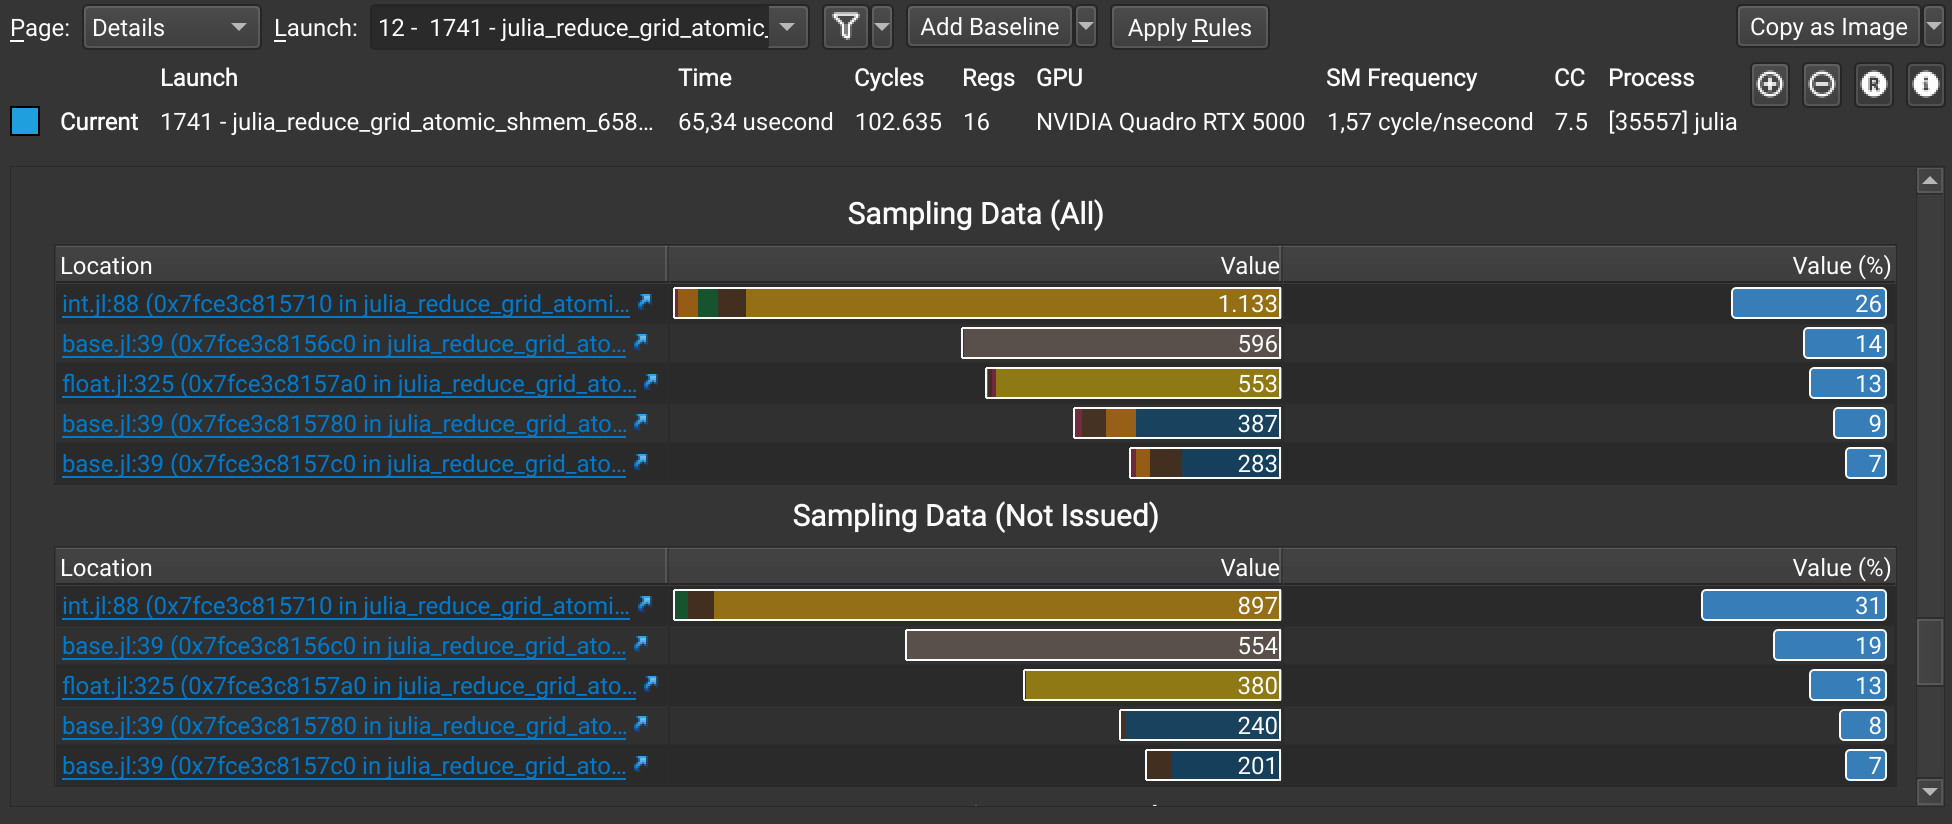

# Common issues

The most frequent issues with the GPU stack come from expected CPU functionality not being implemented or supported on the GPU.

## Unsupported array operations

For example, with array expressions, missing operations often lead to the use of iterating fallback functionality, which triggers the scalar iteration error:

In [64]:
using LinearAlgebra
eigen(CUDA.rand(2,2))

LoadError: Scalar indexing is disallowed.
Invocation of getindex resulted in scalar indexing of a GPU array.
This is typically caused by calling an iterating implementation of a method.
Such implementations *do not* execute on the GPU, but very slowly on the CPU,
and therefore are only permitted from the REPL for prototyping purposes.
If you did intend to index this array, annotate the caller with @allowscalar.

This doesn't mean that this operation cannot work on the GPU, but just that nobody has taken the time to implement `eigen` (or one of the functions it calls) using either functionality from NVIDIA's libraries, or using a native GPU kernel written in Julia.

With array operations, it's also easy to get an error when using unsupported data with GPU kernels. Essentially, every value passed to a kernel needs to be an `isbits` type. An easy way to violate this, is to pass a CPU array to a GPU array operation:

In [65]:
a = CUDA.rand(2,2)
b = rand(2)
broadcast(a, b) do x, y
    x + y
end

LoadError: GPU compilation of kernel broadcast_kernel(CUDA.CuKernelContext, CuDeviceMatrix{Float64, 1}, Base.Broadcast.Broadcasted{Nothing, Tuple{Base.OneTo{Int64}, Base.OneTo{Int64}}, var"#41#42", Tuple{Base.Broadcast.Extruded{CuDeviceMatrix{Float32, 1}, Tuple{Bool, Bool}, Tuple{Int64, Int64}}, Base.Broadcast.Extruded{Vector{Float64}, Tuple{Bool}, Tuple{Int64}}}}, Int64) failed
KernelError: passing and using non-bitstype argument

Argument 4 to your kernel function is of type Base.Broadcast.Broadcasted{Nothing, Tuple{Base.OneTo{Int64}, Base.OneTo{Int64}}, var"#41#42", Tuple{Base.Broadcast.Extruded{CuDeviceMatrix{Float32, 1}, Tuple{Bool, Bool}, Tuple{Int64, Int64}}, Base.Broadcast.Extruded{Vector{Float64}, Tuple{Bool}, Tuple{Int64}}}}, which is not isbits:
  .args is of type Tuple{Base.Broadcast.Extruded{CuDeviceMatrix{Float32, 1}, Tuple{Bool, Bool}, Tuple{Int64, Int64}}, Base.Broadcast.Extruded{Vector{Float64}, Tuple{Bool}, Tuple{Int64}}} which is not isbits.
    .2 is of type Base.Broadcast.Extruded{Vector{Float64}, Tuple{Bool}, Tuple{Int64}} which is not isbits.
      .x is of type Vector{Float64} which is not isbits.



## Unsupported kernel operations

In device code, i.e. code that actually runs on the GPU as opposed to a CPU method (like `eigen`) that's implemented using GPU kernels, the story is a little more complicated. Essentially, not all of the Julia language is supported. If you use unsupported functionality, you will see a compilation error:

In [66]:
a = CUDA.rand(1)
broadcast(a) do x
    print(x)
end

LoadError: InvalidIRError: compiling kernel broadcast_kernel(CUDA.CuKernelContext, CuDeviceVector{Nothing, 1}, Base.Broadcast.Broadcasted{Nothing, Tuple{Base.OneTo{Int64}}, var"#43#44", Tuple{Base.Broadcast.Extruded{CuDeviceVector{Float32, 1}, Tuple{Bool}, Tuple{Int64}}}}, Int64) resulted in invalid LLVM IR
Reason: unsupported call to the Julia runtime (call to jl_subtype)
Stacktrace:
 [1] [0m[1mprint[22m
[90m   @ [39m[90m./[39m[90;4mcoreio.jl:3[0m
 [2] [0m[1m#43[22m
[90m   @ [39m[90m./[39m[90;4mIn[66]:3[0m
 [3] [0m[1m_broadcast_getindex_evalf[22m
[90m   @ [39m[90m./[39m[90;4mbroadcast.jl:648[0m
 [4] [0m[1m_broadcast_getindex[22m
[90m   @ [39m[90m./[39m[90;4mbroadcast.jl:621[0m
 [5] [0m[1mgetindex[22m
[90m   @ [39m[90m./[39m[90;4mbroadcast.jl:575[0m
 [6] [0m[1mbroadcast_kernel[22m
[90m   @ [39m[90m~/Julia/depot/packages/GPUArrays/8dzSJ/src/host/[39m[90;4mbroadcast.jl:59[0m
Reason: unsupported dynamic function invocation (call to print)
Stacktrace:
 [1] [0m[1mprint[22m
[90m   @ [39m[90m./[39m[90;4mcoreio.jl:3[0m
 [2] [0m[1m#43[22m
[90m   @ [39m[90m./[39m[90;4mIn[66]:3[0m
 [3] [0m[1m_broadcast_getindex_evalf[22m
[90m   @ [39m[90m./[39m[90;4mbroadcast.jl:648[0m
 [4] [0m[1m_broadcast_getindex[22m
[90m   @ [39m[90m./[39m[90;4mbroadcast.jl:621[0m
 [5] [0m[1mgetindex[22m
[90m   @ [39m[90m./[39m[90;4mbroadcast.jl:575[0m
 [6] [0m[1mbroadcast_kernel[22m
[90m   @ [39m[90m~/Julia/depot/packages/GPUArrays/8dzSJ/src/host/[39m[90;4mbroadcast.jl:59[0m

To help debugging this, there's multiple stacktraces being displayed: one pointing to each unsupported operation in a GPU kernel, and finally a host stack trace pointing to the CPU code that invoked the kernel. Often, that's sufficient to find and resolve the issue.

Sometimes though, the issue is more subtle:

In [67]:
function bad_kernel(a)
    a[threadId().x] = 0
    return
end

@cuda bad_kernel(CuArray([1]))

LoadError: InvalidIRError: compiling kernel bad_kernel(CuDeviceVector{Int64, 1}) resulted in invalid LLVM IR
Reason: unsupported dynamic function invocation (call to setindex!)
Stacktrace:
 [1] [0m[1mbad_kernel[22m
[90m   @ [39m[90m./[39m[90;4mIn[67]:2[0m
Reason: unsupported use of an undefined name (use of 'threadId')
Stacktrace:
 [1] [0m[1mbad_kernel[22m
[90m   @ [39m[90m./[39m[90;4mIn[67]:2[0m
Reason: unsupported dynamic function invocation
Stacktrace:
 [1] [0m[1mbad_kernel[22m
[90m   @ [39m[90m./[39m[90;4mIn[67]:2[0m
Reason: unsupported dynamic function invocation (call to getproperty)
Stacktrace:
 [1] [0m[1mbad_kernel[22m
[90m   @ [39m[90m./[39m[90;4mIn[67]:2[0m

Here, the issue isn't obvious, with the stack traces pointing to seemingly OK code. In such cases, code reflection utilities can help. All GPU back-ends based on GPUCompiler.jl (i.e. CUDA.jl, AMDGPU.jl and oneAPI.jl) have device-versions of typical reflection utilities like `@code_warntype` or `code_llvm`:

In [68]:
@device_code_warntype @cuda bad_kernel(CuArray([1]))

PTX CompilerJob of kernel bad_kernel(CuDeviceVector{Int64, 1}) for sm_75

Variables
  #self#::Core.Const(bad_kernel)
  a::CuDeviceVector{Int64, 1}

Body::Nothing
1 ─ %1 = Main.threadId()::Any
│   %2 = Base.getproperty(%1, :x)::Any
│        Base.setindex!(a, 0, %2)
└──      return nothing


LoadError: InvalidIRError: compiling kernel bad_kernel(CuDeviceVector{Int64, 1}) resulted in invalid LLVM IR
Reason: unsupported dynamic function invocation (call to setindex!)
Stacktrace:
 [1] [0m[1mbad_kernel[22m
[90m   @ [39m[90m./[39m[90;4mIn[67]:2[0m
Reason: unsupported use of an undefined name (use of 'threadId')
Stacktrace:
 [1] [0m[1mbad_kernel[22m
[90m   @ [39m[90m./[39m[90;4mIn[67]:2[0m
Reason: unsupported dynamic function invocation
Stacktrace:
 [1] [0m[1mbad_kernel[22m
[90m   @ [39m[90m./[39m[90;4mIn[67]:2[0m
Reason: unsupported dynamic function invocation (call to getproperty)
Stacktrace:
 [1] [0m[1mbad_kernel[22m
[90m   @ [39m[90m./[39m[90;4mIn[67]:2[0m

From this view, it's much more clear that `threadId` was a typo and should be `threadIdx` instead. Note that in case your issue lies in a function that's called by the kernel, and isn't directly visible by the `@device_code_warntype` output, you can use Cthulhu.jl to interactively explore code by using `@device_code_warntype interactive=true ...` (the equivalent of Cthulhu's `@descend_code_warntype`).

And just to demonstrate the other reflection utilities:

In [69]:
function good_kernel(a)
    @inbounds a[threadIdx().x] = 0
    return
end

@device_code_llvm @cuda good_kernel(CuArray([1]))

; PTX CompilerJob of kernel good_kernel(CuDeviceVector{Int64, 1}) for sm_75
;  @ In[69]:1 within `good_kernel'
define ptx_kernel void @_Z23julia_good_kernel_1741113CuDeviceArrayI5Int64Li1ELi1EE({ i8 addrspace(1)*, i64, [1 x i64] } %0) local_unnamed_addr {
entry:
  %.fca.0.extract = extractvalue { i8 addrspace(1)*, i64, [1 x i64] } %0, 0
;  @ In[69]:2 within `good_kernel'
; ┌ @ /home/tim/Julia/depot/packages/CUDA/lwSps/src/device/intrinsics/indexing.jl:90 within `threadIdx'
; │┌ @ /home/tim/Julia/depot/packages/CUDA/lwSps/src/device/intrinsics/indexing.jl:46 within `threadIdx_x'
; ││┌ @ /home/tim/Julia/depot/packages/CUDA/lwSps/src/device/intrinsics/indexing.jl:6 within `_index'
; │││┌ @ /home/tim/Julia/depot/packages/CUDA/lwSps/src/device/intrinsics/indexing.jl:6 within `macro expansion' @ /home/tim/Julia/depot/packages/LLVM/aqg20/src/interop/base.jl:39
      %1 = call i32 @llvm.nvvm.read.ptx.sreg.tid.x()
; ││└└
; ││┌ @ boot.jl:752 within `Int64'
; │││┌ @ boot.jl:676 within `toInt64'
 

In [70]:
CUDA.code_ptx(good_kernel, Tuple{CuDeviceVector{Int64, 1}})

//
// Generated by LLVM NVPTX Back-End
//

.version 6.3
.target sm_75
.address_size 64

	// .globl	julia_good_kernel_17539 // -- Begin function julia_good_kernel_17539
.visible .func julia_good_kernel_17539
(
	.param .b64 julia_good_kernel_17539_param_0
)
;
.weak .global .align 8 .u64 julia_good_kernel_17539_slot = julia_good_kernel_17539;
                                        // @julia_good_kernel_17539
.visible .func julia_good_kernel_17539(
	.param .b64 julia_good_kernel_17539_param_0
)
{
	.reg .b32 	%r<2>;
	.reg .b64 	%rd<6>;

// %bb.0:                               // %top
	ld.param.u64 	%rd1, [julia_good_kernel_17539_param_0];
	mov.u32 	%r1, %tid.x;
	ld.u64 	%rd2, [%rd1];
	mul.wide.u32 	%rd3, %r1, 8;
	add.s64 	%rd4, %rd2, %rd3;
	mov.u64 	%rd5, 0;
	st.global.u64 	[%rd4], %rd5;
	ret;
                                        // -- End function
}


In [71]:
CUDA.code_sass(good_kernel, Tuple{CuDeviceVector{Int64, 1}})

	.headerflags	@"EF_CUDA_TEXMODE_UNIFIED EF_CUDA_64BIT_ADDRESS EF_CUDA_SM75 EF_CUDA_VIRTUAL_SM(EF_CUDA_SM75)"
	.elftype	@"ET_EXEC"


//--------------------- .text._Z23julia_good_kernel_1760913CuDeviceArrayI5Int64Li1ELi1EE --------------------------
	.section	.text._Z23julia_good_kernel_1760913CuDeviceArrayI5Int64Li1ELi1EE,"ax",@progbits
	.sectioninfo	@"SHI_REGISTERS=6"
	.align	128
        .global         _Z23julia_good_kernel_1760913CuDeviceArrayI5Int64Li1ELi1EE
        .type           _Z23julia_good_kernel_1760913CuDeviceArrayI5Int64Li1ELi1EE,@function
        .size           _Z23julia_good_kernel_1760913CuDeviceArrayI5Int64Li1ELi1EE,(.L_20 - _Z23julia_good_kernel_1760913CuDeviceArrayI5Int64Li1ELi1EE)
        .other          _Z23julia_good_kernel_1760913CuDeviceArrayI5Int64Li1ELi1EE,@"STO_CUDA_ENTRY STV_DEFAULT"
_Z23julia_good_kernel_1760913CuDeviceArrayI5Int64Li1ELi1EE:

.text._Z23julia_good_kernel_1760913CuDeviceArrayI5Int64Li1ELi1EE:
; Location ./In[69]:1
        MOV R1, c[0x0][0x28

## Parallel programming issues

Finally, it's also easy to run into issues related to parallel programming: threads need to be synchronized, memories initialized, etc. Mistakes are easy to make, for example, let's look at this kernel to transpose a matrix:

In [72]:
const tile_dim = 16

function gpu_transpose(input::CuMatrix)
    function kernel(input::AbstractMatrix{T}, output::AbstractMatrix{T}) where {T}
        # shared memory buffer so that operations to global memory are linear and can be coalesced
        block = @cuStaticSharedMem(T, (tile_dim, tile_dim))

        # read
        x = tile_dim * (blockIdx().x - 1) + threadIdx().x
        y = tile_dim * (blockIdx().y - 1) + threadIdx().y
        if x <= size(input, 1) && y <= size(input, 2)
            block[threadIdx().y, threadIdx().x] = input[x, y]
        end

        # write
        x = tile_dim * (blockIdx().y - 1) + threadIdx().x
        y = tile_dim * (blockIdx().x - 1) + threadIdx().y
        if x <= size(output, 1) && y <= size(output, 2)
            output[x, y] = block[threadIdx().x, threadIdx().y]
        end
        return
    end
    
    output = similar(input, reverse(size(input)))
    @cuda threads=(tile_dim, tile_dim) blocks=(cld(size(input, 1), tile_dim), cld(size(input, 2), tile_dim)) kernel(input, output)
    output
end

a = CuArray(reshape(1:1024, 32, 32))
b = gpu_transpose(a)
display(b)
println("Valid transpose: ", Array(b) == Array(a)')

32×32 CuArray{Int64, 2}:
   1    2    3    4    5    6    7     8  …    27    28   29   30    31    32
  33   34   35   36   37   38   39    40       59    60   61   62    63    64
  65   66   67   68   69   70   71    72       91    92   93   94    95    96
  97   98   99  100  101  102  103   104      123   124  125  126   127   128
 129  130  131  132  133  134  135   136      155   156  157  158   159   160
 161  162  163  164  165  166  167   168  …   187   188  189  190   191   192
 193  194  195  196  197  198  199   200      219   220  221  222   223   224
 225  226  227  228  229  230  231   232      251   252  253  254   255   256
 257  258  259  260  261  262  263   264      283   284  285  286   287   288
 289  290  291  292  293  294  295   296      315   316  317  318   319   320
 321  322  323  324  325  326  327   328  …   347   348  349  350   351   352
 353  354  355  356  357  358  359   360      379   380  381  382   383   384
 385  386  387  388  389  390  391   39

Valid transpose: false


If we execute this kernel a couple of times, we see some strange values in the matrix. This may be caused by a race condition, which NVIDIA has tools for to discover.

With the compute sanitizer, https://docs.nvidia.com/cuda/compute-sanitizer/index.html, one can run `julia` under several sanitizer tools detecting issues like memory errors, race conditions, or missing synchronization. The sanitizer is shipped as part of CUDA.jl, but cannot be launched from within a session:

In [73]:
CUDA.compute_sanitizer()

"/home/tim/Julia/depot/artifacts/0ed779f9e1d7b0c9905eb5be2c4349d32fbeb050/bin/compute-sanitizer"

Let's put this kernel in a dedicated file:
```
a = CUDA.ones(1024,1024)
b = gpu_transpose(a)
@assert Array(b) == Array(a)'
```

And run it under the compute sanitizer (we'll be using the `racecheck` tool since we're suspecting a race):

```
$ /path/to/compute-sanitizer --launch-timeout=0 --report-api-errors=no --tool=racecheck julia wip.jl
========= COMPUTE-SANITIZER
========= ERROR: Race reported between Write access at 0x320 in
          LLVM/src/interop/base.jl:39:julia_kernel_3102(CuDeviceArray<Float32, (int)2, (int)1>,
          CuDeviceArray<Float32, (int)2, (int)1>)
========= and Read access at 0x520 in int.jl:86:julia_kernel_3102(CuDeviceArray<Float32, (int)2, (int)1>,
          CuDeviceArray<Float32, (int)2, (int)1>) [3932160 hazards]
========= 
ERROR: LoadError: AssertionError: Array(b) == (Array(a))'
```

Note the `--launch-timeout=0` argument, to give Julia some time to perform the first CUDA API call, and `--report-api-errors=no` to hide probably unrelated API errors (that can come from a variety of places, including NVIDIA's own libraries).